# Recommender system and content based filtering 
## Gustavo Augusto Mondragón Sánchez

**------------------------------------------------------------------------------------------------**

## Python enviroment configuration

In [1]:
#!pip install numpy cython
#!pip install six==1.10.0
#!pip install msrest==0.4.5
#!pip install scipy==1.0.0
#!pip install fastlmm
#!pip install argparse
#!pip install scipy
#!pip install -U turicreate
#!pip install scikit-surprise

## Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
np.set_printoptions(precision=4)

## Rating dataset  and configuration

In [3]:
ratings = pd.read_csv('ratingClean.csv')

In [4]:
ratings = ratings[['userID_auto','placeID_auto','rating']]
n = len(ratings)
ratings.info()
ratings.head(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1161 entries, 0 to 1160
Data columns (total 3 columns):
userID_auto     1161 non-null int64
placeID_auto    1161 non-null int64
rating          1161 non-null int64
dtypes: int64(3)
memory usage: 27.3 KB


,userID_auto,placeID_auto,rating
0,76,123,2
1,76,84,2
2,76,31,2


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f86d0865d30>]],
      dtype=object)

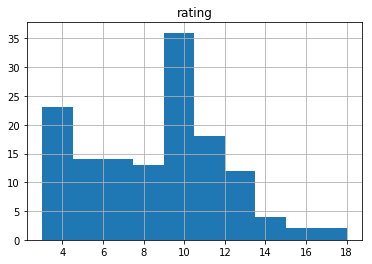

In [5]:
aux = ratings[['userID_auto','rating']]
aux.groupby('userID_auto').count().hist()

# 1. What would be the best recommendation for diners? Provide problem statement and codes in Python (preference) or R.

### Problem statement:
We want to get a top-n best restaurants recommendation by user. 

### "Surprise" recommender library

In [6]:
from __future__ import (absolute_import, division, print_function,
                        unicode_literals)

from surprise import KNNWithMeans
from surprise import dataset
from surprise import Reader
from surprise import evaluate, print_perf
from surprise.model_selection import cross_validate
from surprise import accuracy
from surprise.model_selection import train_test_split

### Model

In [7]:
# Load the ratings dataset. 
reader = Reader(line_format='user item rating', rating_scale=(1, 2))

# Also, a dummy Dataset class
class MyDataset(dataset.DatasetAutoFolds):

    def __init__(self, df, reader):

        self.raw_ratings = [(uid, iid, r, None) for (uid, iid, r) in
                            zip(df['userID_auto'], df['placeID_auto'], df['rating'])]
        self.reader=reader

data = MyDataset(ratings, reader)
trainset, testset = train_test_split(data, test_size=.15)

algo = KNNWithMeans(k=10, sim_options={'name': 'pearson_baseline', 'user_based': True})
#algo.fit(trainset)
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)
0

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Evaluating RMSE, MAE of algorithm KNNWithMeans on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.7429  0.7601  0.7288  0.7338  0.7278  0.7387  0.0120  
MAE (testset)     0.5727  0.6075  0.5854  0.5658  0.5679  0.5799  0.0154  
Fit time          0.03    0.04    0.04    0.03    0.04    0.04    0.00    
Test time         0.03    0.03    0.05    0.04    0.

0

In [8]:
# we can now query for specific predicions
uid = str(50)  # raw user id
iid = str(50)  # raw item id

# get a prediction for specific users and items.
pred = algo.predict(uid, iid, r_ui=2, verbose=True)

user: 50         item: 50         r_ui = 2.00   est = 1.20   {'was_impossible': True, 'reason': 'User and/or item is unkown.'}


# 2. Provide an explanation of the assumptions used and their results.

A collaborative filtering is a method of making automatic predictions about interest of the users. The main idea is that user may have similar preferences, so when two very similar user hace very little diferences they may have the oportinity of recommend each other some items. 

* User-user Collaborative Filtering: under this model prediction is set as:
<img src="ColabFilter.PNG" alt="Drawing" style="width: 450px;"/>
* Where we make a mean "normalization" to get a mean based recommendation when a user or a restaurant don't have their feature specified. 
* We utilize the similarity measure between user u and user v.

In [9]:
# run the trained model against the testset
test_pred = algo.test(testset)

# get RMSE
print("User-based Model : Test Set")
accuracy.rmse(test_pred, verbose=True)

# if you wanted to evaluate on the trainset
print("User-based Model : Training Set")
train_pred = algo.test(trainset.build_testset())
accuracy.rmse(train_pred)

User-based Model : Test Set
RMSE: 0.5049
User-based Model : Training Set
RMSE: 0.5304


0.5303955638039176

As we can see, the RMSE is very high jet (lower than 0.5 would be usefull). To improve the score maybe an algorithm that use profile information would help, a posible feature transformation is in dataProfiling books. 

# 3. Under the suposition that new restaurants were included, how would you calculate their ratings? Just write the statement of how you would estimate the rating; no codes are necessary.
* Option 1, **K nearst neigborh**: the rating could be the mean value of the k nearst elements. We can use KNN or any clustering algorithm to get the most similar objetcts. We can use the restaurant profile and other datasets to get features about the restaurants and calculate the distance with euclidean or cosine metrics.

### Top 5 redommendation

In [11]:
from collections import defaultdict

def get_top_n(predictions, n=10):
    '''Return the top-N recommendation for each user from a set of predictions.

    Args:
        predictions(list of Prediction objects): The list of predictions, as
            returned by the test method of an algorithm.
        n(int): The number of recommendation to output for each user. Default
            is 10.

    Returns:
    A dict where keys are user (raw) ids and values are lists of tuples:
        [(raw item id, rating estimation), ...] of size n.
    '''

    # First map the predictions to each user.
    top_n = defaultdict(list)
    for uid, iid, true_r, est, _ in predictions:
        top_n[uid].append((iid, est))

    # Then sort the predictions for each user and retrieve the k highest ones.
    for uid, user_ratings in top_n.items():
        user_ratings.sort(key=lambda x: x[1], reverse=True)
        top_n[uid] = user_ratings[:n]

    return top_n

top_n = get_top_n(test_pred, n=5)

# Print the recommended items for each user
for uid, user_ratings in top_n.items():
    print(uid, [iid for (iid, _) in user_ratings])

86 [22]
44 [31, 98]
32 [78]
60 [82, 76, 120, 117, 3]
89 [53, 97]
36 [44]
104 [86, 32]
23 [91, 115, 78, 77, 127]
5 [49, 56]
21 [81, 80, 121]
109 [70, 28, 74]
57 [50, 89]
98 [105, 89, 88]
77 [98]
103 [123, 85, 87, 93]
117 [68]
122 [126, 6, 16]
100 [98, 77, 97]
49 [24]
133 [116, 117, 120]
96 [124, 58]
84 [50, 46]
114 [122]
14 [113]
40 [129]
18 [33, 51]
29 [72, 129, 65]
120 [28]
97 [105]
58 [123, 57, 25, 117, 78]
4 [96]
80 [89, 31]
113 [21, 109]
68 [36, 128]
0 [85]
111 [124, 92, 33]
121 [99]
124 [96, 88, 89]
52 [121, 106, 107, 31]
129 [12]
12 [3]
17 [111]
70 [80, 78]
73 [69]
99 [29]
61 [123, 33]
37 [40, 38]
75 [115]
11 [65]
33 [101, 49]
47 [82, 76, 94]
132 [27, 61]
24 [48, 31, 93]
1 [87, 53]
31 [105, 123]
26 [51]
46 [48]
56 [56]
108 [31]
95 [101, 124, 21]
83 [41]
119 [34]
62 [5, 13]
107 [103]
123 [128, 111, 96]
63 [102]
72 [55, 109]
110 [40]
88 [108, 33, 103]
85 [51]
34 [67]
136 [26]
53 [106]
69 [9]
102 [23, 14]
79 [2]
55 [77, 118]
27 [9]
90 [49, 117]
3 [127]
116 [67]
81 [22]
125 [86]
8 [1

### References:
* Surprise GitHub repository
https://github.com/NicolasHug/Surprise
http://surpriselib.com/
* Analytics Vidhya blog: *Comprehensive Guide to build a Recommendation Engine from scratch (in Python)*
https://www.analyticsvidhya.com/blog/2018/06/comprehensive-guide-recommendation-engine-python/
* Medium.com *USER-USER Collaborative filtering Recommender System in Python*
https://medium.com/@tomar.ankur287/user-user-collaborative-filtering-recommender-system-51f568489727